# Imports & Configuration

In [9]:
import sys, os
# Ensure project root (one level up from notebooks/) is visible to Python
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [16]:
# Core libraries
import pandas as pd
import numpy as np

# Modeling
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

# Utilities
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, make_scorer
)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os


# Load Data

In [14]:
import pandas as pd

# One folder back (since notebooks/ is one level below project root)
df = pd.read_csv("../data/processed/merged_clean_refined.csv")

target_col = "DeclineFlag"   # binary target
group_col = "player_id"      # check if exists; if not, we’ll handle it below

# Check for player_id or create one if missing
if "player_id" not in df.columns:
    df["player_id"] = df.index  # temporary group ID for cross-validation

feature_cols = [c for c in df.columns if c not in [target_col, group_col]]

X = df[feature_cols]
y = df[target_col]
groups = df[group_col]

print("Dataset shape:", X.shape)
print("Target value counts:\n", y.value_counts(normalize=True).round(3))

Dataset shape: (4829, 19)
Target value counts:
 DeclineFlag
0.0    0.608
1.0    0.392
Name: proportion, dtype: float64


# Define Cross-Validation & Scoring

In [17]:
cv = GroupKFold(n_splits=5)

scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc"
}

# Define Baseline Models

In [18]:
models = {
    "Dummy": DummyClassifier(strategy="most_frequent"),
    "Logistic": LogisticRegression(max_iter=500, solver="liblinear"),
    "DecisionTree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}


## Preprocessor to the Textual Cols

In [24]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Detect column types
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

print("Categorical columns:", cat_cols)
print("Numerical columns:", num_cols)

# Define preprocessing with imputation
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)



Categorical columns: ['from_league', 'to_league', 'Position', 'sub_position', 'position', 'foot', 'country_of_birth', 'country_of_citizenship', 'transfer_date', 'date_of_birth', 'contract_expiration_date']
Numerical columns: ['GA90_pre', 'GA_pre', 'PreMinutes', 'transfer_fee', 'market_value_in_eur', 'market_value_in_eur_player', 'highest_market_value_in_eur', 'height_in_cm']


# Cross-Validation Evaluation

In [25]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

models = {
    "Dummy": Pipeline([
        ("preprocess", preprocessor),
        ("model", DummyClassifier(strategy="most_frequent"))
    ]),
    "Logistic": Pipeline([
        ("preprocess", preprocessor),
        ("model", LogisticRegression(max_iter=500, solver="liblinear"))
    ]),
    "DecisionTree": Pipeline([
        ("preprocess", preprocessor),
        ("model", DecisionTreeClassifier(max_depth=5, random_state=42))
    ]),
    "RandomForest": Pipeline([
        ("preprocess", preprocessor),
        ("model", RandomForestClassifier(n_estimators=100, random_state=42))
    ])
}


In [26]:
from sklearn.model_selection import cross_validate
import numpy as np
import pandas as pd

results = []

for name, model in models.items():
    print(f"Training {name}...")
    scores = cross_validate(
        model,
        X, y,
        groups=groups,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )

    results.append({
        "model": name,
        "accuracy": np.mean(scores["test_accuracy"]),
        "precision": np.mean(scores["test_precision"]),
        "recall": np.mean(scores["test_recall"]),
        "f1": np.mean(scores["test_f1"]),
        "roc_auc": np.mean(scores["test_roc_auc"])
    })

results_df = pd.DataFrame(results).sort_values("f1", ascending=False)
results_df


Training Dummy...
Training Logistic...
Training DecisionTree...
Training RandomForest...


,model,accuracy,precision,recall,f1,roc_auc
3,RandomForest,0.811766,0.846173,0.636686,0.725157,0.899856
1,Logistic,0.783804,0.761643,0.653464,0.702884,0.846749
2,DecisionTree,0.692899,0.686779,0.401343,0.504357,0.729796
0,Dummy,0.608202,0.000000,0.000000,0.000000,0.500000


# Visualization of Model Performance

C:\Users\Pouya\AppData\Local\Temp\ipykernel_1792\381423296.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="model", y="f1", palette="Blues_r")


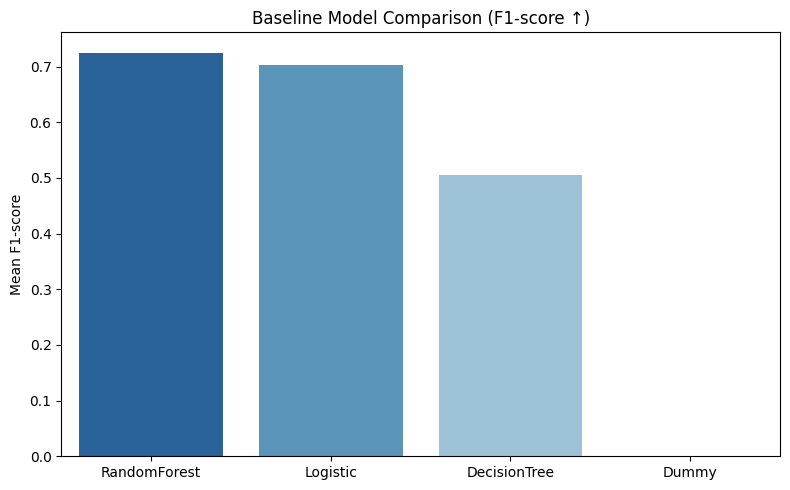

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x="model", y="f1", palette="Blues_r")
plt.title("Baseline Model Comparison (F1-score ↑)")
plt.ylabel("Mean F1-score")
plt.xlabel("")
plt.tight_layout()
plt.show()


# Save Results Table

In [28]:
import os

os.makedirs("../results", exist_ok=True)
results_path = "../results/model_comparison_baselines_classification.csv"
results_df.to_csv(results_path, index=False)
print(f"Saved results to {results_path}")


Saved results to ../results/model_comparison_baselines_classification.csv


# Retrain and Save the Best Model (Full Pipeline)

In [29]:
import joblib

best_model_name = results_df.iloc[0]["model"]
best_model = models[best_model_name]

print(f"Retraining best model: {best_model_name}")
best_model.fit(X, y)

os.makedirs("../artifacts", exist_ok=True)
model_path = f"../artifacts/{best_model_name}_baseline_pipeline.joblib"
joblib.dump(best_model, model_path)
print(f"Full pipeline (including preprocessing) saved to {model_path}")


Retraining best model: RandomForest
Full pipeline (including preprocessing) saved to ../artifacts/RandomForest_baseline_pipeline.joblib


# Feature Importance / Coefficients

In [32]:
best_model_name

'RandomForest'

C:\Users\Pouya\AppData\Local\Temp\ipykernel_1792\3663130511.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df.head(10), x="importance", y="feature", palette="magma")


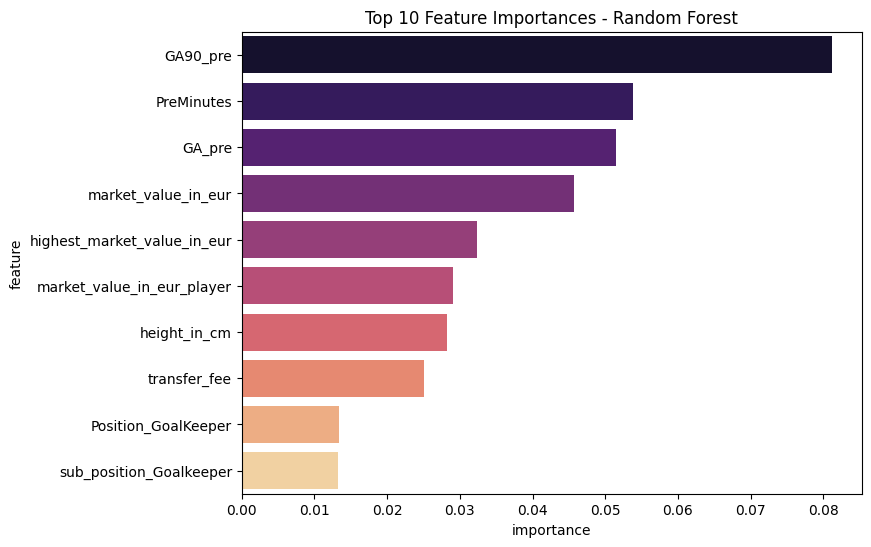

In [30]:
inner_model = best_model.named_steps["model"]

if best_model_name == "RandomForest":
    # Get all encoded feature names
    cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
    num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()
    encoder = best_model.named_steps["preprocess"].named_transformers_["cat"].named_steps["encoder"]
    encoded_cat_features = encoder.get_feature_names_out(cat_cols)
    all_features = np.concatenate([num_cols, encoded_cat_features])

    importances = inner_model.feature_importances_
    imp_df = pd.DataFrame({
        "feature": all_features,
        "importance": importances
    }).sort_values("importance", ascending=False)

    plt.figure(figsize=(8, 6))
    sns.barplot(data=imp_df.head(10), x="importance", y="feature", palette="magma")
    plt.title("Top 10 Feature Importances - Random Forest")
    plt.show()
